<a href="https://colab.research.google.com/github/jaysmerrill/Yaquina_Bay_Seiching/blob/main/seiche_prediction_patchtst_20250930.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

46050 2008: 7,189 rows
46050 2009: 8,740 rows
46050 2010: 8,738 rows
46050 2011: 8,055 rows
46050 2012: 8,746 rows
46050 2013: 8,745 rows
46050 2014: 8,754 rows
46050 2015: 8,472 rows
46050 2016: 8,688 rows
46050 2017: 28,478 rows
46050 2018: 52,403 rows
46050 2019: 52,055 rows
46050 2020: 52,211 rows
46050 2021: 51,561 rows
46050 2022: 52,531 rows
46050 2023: 52,486 rows
46050 2024: 52,695 rows
Unified mask: kept 1,264,580/1,269,412 rows (~99.6%).

Top lag-specific (raw) — first 20:
  wsp_lag_630min                           0.087538
  APD_lag_0min                             0.082205
  wl_gradient_lag_30min                    0.042133
  HIG_lag_30min                            0.041571
  APD_lag_30min                            0.041423
  gust_lag_600min                          0.030383
  HIG_lag_60min                            0.029311
  Hs_lag_150min                            0.028259
  gust_lag_330min                          0.027577
  HIG_lag_90min                            

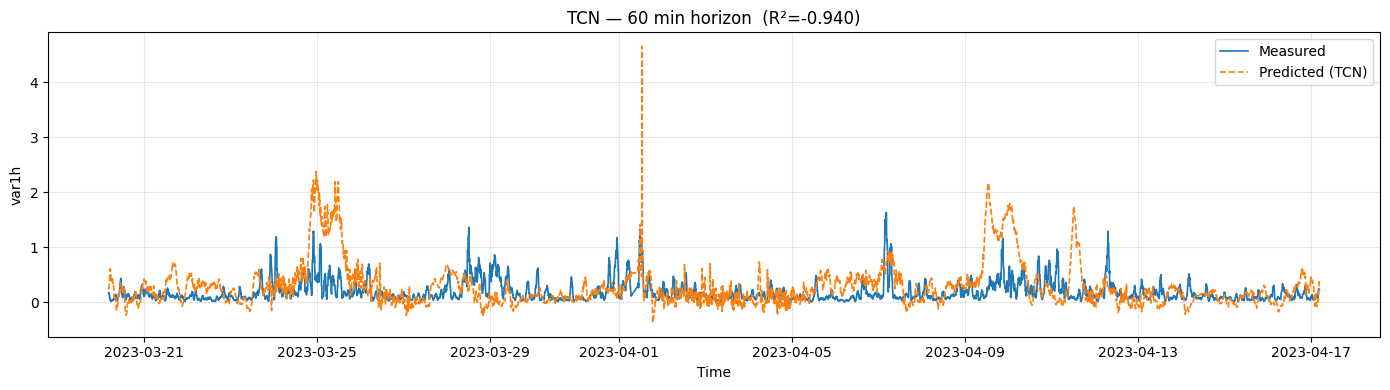

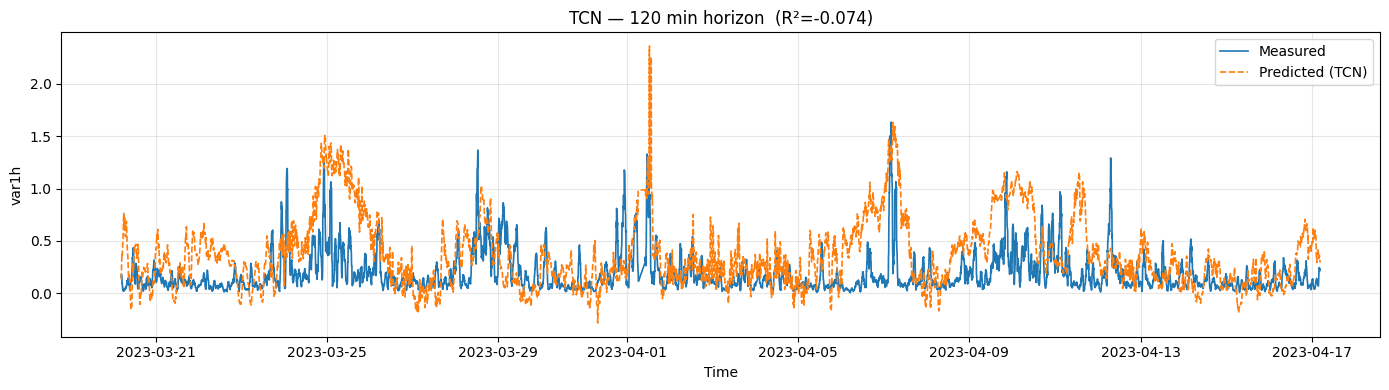

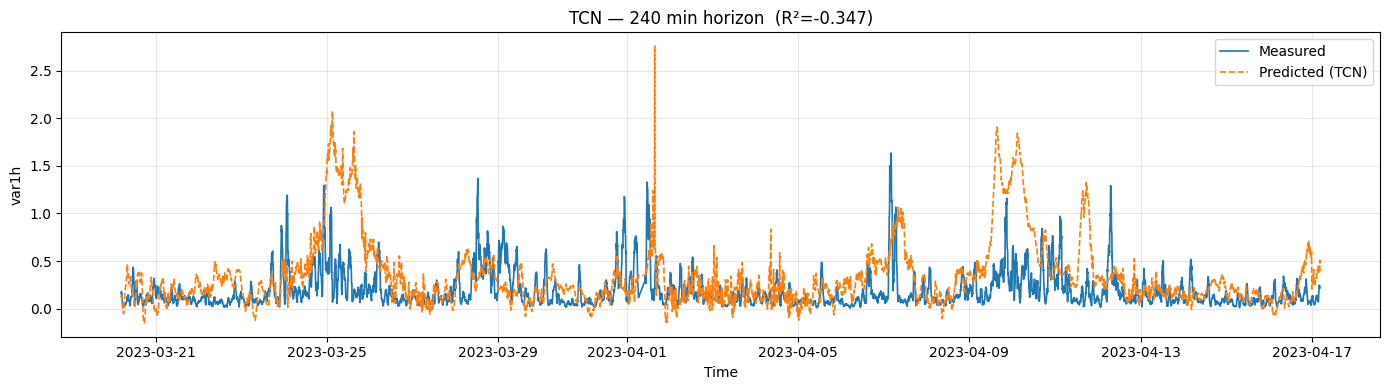


Done.


In [6]:
# ============================================================
# End-to-end: NOAA 46050 -> align -> unified gap mask -> XGB top-10 (≤2/base) -> TCN (60/120/240)
# ============================================================
import io, gzip, re, requests, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from contextlib import nullcontext

# -------------------
# USER KNOBS
# -------------------
DATA_PATH          = None  # e.g., "/content/input_matrix_for_ML_AI_applications.parquet" (set if df_seq not already defined)
YEARS              = list(range(2008, 2025))   # NDBC 46050 historical stdmet years to fetch
DT_MINUTES         = 6
MAX_GAP_HOURS      = 5                         # do not bridge gaps bigger than this
HISTORY_HOURS      = 12                        # past context per sample
HORIZONS_MIN       = [60, 120, 240]            # 1h, 2h, 4h
PRIMARY_HORIZON    = 60                        # horizon used for XGB ranking
TOP_LAG_FEATURES   = 10                        # keep top-10 lag-specific features
PER_BASE_CAP       = 2                         # ≤2 features from the same base in the top-10
LAGS_WL_HOURS      = [0.5*i for i in range(0, 5)]     # 0..2h in 0.5h steps for wl_low & wl_gradient
LAGS_OTHER_HOURS   = [0.5*i for i in range(0, 25)]    # 0..12h in 0.5h steps for others
ATM_SPIKE_ALPHA    = 2.0                       # atmvar1 upper-tail emphasis
ATM_SPIKE_POWER    = 1.0
TRAIN_END          = pd.Timestamp("2018-12-31 23:59:59")
VAL_END            = pd.Timestamp("2022-12-31 23:59:59")
BATCH_SIZE         = 256
EPOCHS_TCN         = 6
LEARNING_RATE      = 2e-3
DROPOUT            = 0.2
MAX_SAMPLES_SPLIT  = 60_000
PLOT_LAST_DAYS     = 28

# Downweight/Upweight bases (applied after scaling, per selected lag column base)
BASE_MULTIPLIER = {
    "ef": 0.75,
    "HIG": 0.75,
    "atmvar1_boost": 1.25,
}

# -------------------
# Load or assert df_seq (must have time + var1h; may also contain other columns)
# -------------------
if DATA_PATH is not None and "df_seq" not in globals():
    if DATA_PATH.lower().endswith(".parquet"):
        df_seq = pd.read_parquet(DATA_PATH)
    else:
        df_seq = pd.read_csv(DATA_PATH)
    df_seq["time"] = pd.to_datetime(df_seq["time"])
    df_seq = df_seq.sort_values("time").reset_index(drop=True)

assert "df_seq" in globals(), "Please define df_seq or set DATA_PATH."
assert {"time","var1h"}.issubset(df_seq.columns), "df_seq must include 'time' and 'var1h'."

df_seq["time"] = pd.to_datetime(df_seq["time"])
df_seq = df_seq.sort_values("time").reset_index(drop=True)

# -------------------
# Download + parse NDBC 46050 standard met/wave (robust)
# -------------------
import io, gzip, requests, time
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# If you had YEARS including the current year, trim it (historical often lags):
YEARS = [y for y in YEARS if y < pd.Timestamp.utcnow().year]  # e.g., 2008..2024 (if today is 2025)

DIRECT_PAT = "https://www.ndbc.noaa.gov/data/historical/stdmet/46050h{year}.txt.gz"
PHP_PAT    = "https://www.ndbc.noaa.gov/view_text_file.php?filename=46050h{year}.txt.gz&dir=data/historical/stdmet/"

def _make_session():
    s = requests.Session()
    retry = Retry(
        total=4,
        backoff_factor=0.5,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=["HEAD", "GET", "OPTIONS"],
        raise_on_status=False,
    )
    s.headers.update({
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) ColabFetcher/1.0 (+https://colab.research.google.com)",
        "Accept": "*/*",
    })
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://", HTTPAdapter(max_retries=retry))
    return s

def fetch_year_text(year: int, session: requests.Session) -> str | None:
    # Try direct gz first
    for url in (DIRECT_PAT.format(year=year), PHP_PAT.format(year=year)):
        try:
            r = session.get(url, timeout=30)
            if r.status_code != 200 or not r.content:
                continue
            # Some endpoints return HTML if not found; detect by magic header or content-type
            ctype = r.headers.get("Content-Type", "").lower()
            data = r.content
            # If PHP view returns plain text gzip bytes, still fine; just try to gunzip.
            try:
                with gzip.GzipFile(fileobj=io.BytesIO(data)) as gz:
                    return gz.read().decode("utf-8", errors="ignore")
            except OSError:
                # Not gzipped; if it’s HTML, skip; if it’s plain text, return as-is
                if "html" in ctype or data[:15].lower().startswith(b"<!doctype html"):
                    continue
                try:
                    return data.decode("utf-8", errors="ignore")
                except Exception:
                    continue
        except Exception:
            continue
    return None

session = _make_session()
frames = []
attempt_log = []
for y in YEARS:
    txt = fetch_year_text(y, session)
    if txt:
        df_y = parse_ndbc_stdmet_text(txt)
        if not df_y.empty:
            frames.append(df_y)
            attempt_log.append((y, "OK", len(df_y)))
            print(f"46050 {y}: {len(df_y):,} rows")
        else:
            attempt_log.append((y, "Parsed 0 rows", 0))
            print(f"46050 {y}: parsed 0 rows (format unexpected?)")
    else:
        attempt_log.append((y, "Missing/HTML/404", 0))
        print(f"46050 {y}: not available (skipped)")

if not frames:
    # Helpful diagnostics
    print("\nNo NDBC 46050 files were retrieved. Here’s what happened by year:")
    for y, status, n in attempt_log:
        print(f"  {y}: {status} ({n})")
    print("\nTips:")
    print("• Make sure YEARS excludes the current year (historical archive lags).")
    print("• Try a smaller range first, e.g., YEARS = list(range(2008, 2019)).")
    print("• Verify Colab has internet access; re-run the cell if needed.")
    raise RuntimeError("No NDBC 46050 data parsed after retries.")

df_46050 = pd.concat(frames, axis=0, ignore_index=True)
df_46050 = df_46050.sort_values("time").drop_duplicates(subset=["time"], keep="last").reset_index(drop=True)

# -------------------
# Interpolate buoy to df_seq["time"] WITHOUT bridging long gaps
# -------------------
dt = df_46050["time"].diff().dt.total_seconds().fillna(0.0).values
gap_idx = np.where(dt > MAX_GAP_HOURS * 3600.0)[0]
segments = []
if len(df_46050) > 0:
    start = 0
    for gi in gap_idx:
        segments.append((start, gi-1))
        start = gi
    segments.append((start, len(df_46050)-1))

def seg_interp_to_target(df_seg: pd.DataFrame, t_target: np.ndarray) -> pd.DataFrame:
    seg = df_seg.set_index("time")
    mask = (t_target >= seg.index[0].to_datetime64()) & (t_target <= seg.index[-1].to_datetime64())
    tt = pd.to_datetime(t_target[mask])
    if len(tt) == 0:
        return pd.DataFrame(columns=["time"] + list(seg.columns))
    idx = pd.Index(sorted(set(seg.index.to_list() + tt.to_list())))
    seg2 = seg.reindex(idx).sort_index().interpolate(method="time", limit_area="inside")
    seg2 = seg2.reindex(tt)
    return seg2.reset_index().rename(columns={"index":"time"})

t_target = pd.to_datetime(df_seq["time"]).values
pieces = []
for s, e in segments:
    if e <= s: continue
    out = seg_interp_to_target(df_46050.iloc[s:e+1].copy(), t_target)
    if not out.empty:
        pieces.append(out)

buoy_interp = (pd.concat(pieces, axis=0, ignore_index=True)
               .drop_duplicates(subset=["time"]).sort_values("time")
               if pieces else pd.DataFrame(columns=["time"] + list(NDBC_COL_MAP.values())))

aligned = pd.DataFrame({"time": pd.to_datetime(df_seq["time"])})
aligned = aligned.merge(buoy_interp, on="time", how="left")

merge_cols = list(NDBC_COL_MAP.values())  # ['Hs','APD','gust','wdir','wsp','MWD']
for c in merge_cols:
    if c not in aligned.columns: aligned[c] = np.nan
df_seq = df_seq.merge(aligned[["time"] + merge_cols], on="time", how="left")

# -------------------
# Physics-aware feature engineering
# -------------------
# wl_gradient (if wl_low exists), units per hour
if "wl_low" in df_seq.columns:
    dt_hr = DT_MINUTES / 60.0
    wl_low = pd.to_numeric(df_seq["wl_low"], errors="coerce").astype("float32").values
    df_seq["wl_gradient"] = np.gradient(wl_low, dt_hr).astype("float32")
else:
    df_seq["wl_gradient"] = np.nan

# atmvar1_boost (keep original atmvar1 too)
if "atmvar1" in df_seq.columns:
    x = pd.to_numeric(df_seq["atmvar1"], errors="coerce").astype("float32").values
    p90 = np.nanpercentile(x, 90.0); p95 = np.nanpercentile(x, 95.0)
    scale = max(p95 - p90, 1e-6)
    boost = 1.0 + ATM_SPIKE_ALPHA * np.maximum(0.0, (x - p90) / scale) ** ATM_SPIKE_POWER
    df_seq["atmvar1_boost"] = (x * boost).astype("float32")
else:
    df_seq["atmvar1_boost"] = np.nan

# -------------------
# Unified gap mask across REQUIRED inputs (any missing => drop that timestamp)
# -------------------
required_candidates = ["var1h","wl_low","wl_gradient","atmvar1","atmvar1_boost","Hs","APD","gust","wdir","wsp","MWD"]
REQUIRED_COLS = [c for c in required_candidates if c in df_seq.columns]
before = len(df_seq)
df_seq = df_seq.dropna(subset=REQUIRED_COLS).reset_index(drop=True)
after = len(df_seq)
print(f"Unified mask: kept {after:,}/{before:,} rows (~{100*after/max(1,before):.1f}%).")

# -------------------
# Lagged features + XGBoost selection (≤2 per base)
# -------------------
target_col = "var1h"
for c in df_seq.columns:
    if c != "time":
        df_seq[c] = pd.to_numeric(df_seq[c], errors="coerce").astype("float32")

def base_name(col_with_lag: str) -> str:
    return col_with_lag.split("_lag_")[0] if "_lag_" in col_with_lag else col_with_lag

def lag_steps_for_base(base: str):
    if base in ("wl_low","wl_gradient"):
        return sorted({int(round(h*60/DT_MINUTES)) for h in LAGS_WL_HOURS})
    else:
        return sorted({int(round(h*60/DT_MINUTES)) for h in LAGS_OTHER_HOURS})

# candidate bases = all numeric columns except time & target
all_feats = [c for c in df_seq.columns if c not in ["time", target_col, "var1h_log1p"]]
base_feats = all_feats.copy()

def build_lagged_matrix_per_feature(df: pd.DataFrame, bases: list, target: str, horizon_minutes: int):
    dtm = DT_MINUTES
    h_steps = max(1, int(round(horizon_minutes/dtm)))
    # Build lag block in one shot (avoid fragmentation)
    lag_dict = {}
    for col in bases:
        src = df[col].reset_index(drop=True)
        for s in lag_steps_for_base(col):
            nm = f"{col}_lag_{int(s*dtm)}min"
            lag_dict[nm] = (src.shift(s) if s>0 else src).astype("float32")
    lag_block = pd.DataFrame(lag_dict)
    tgt_name = f"{target}_lead_{horizon_minutes}min"
    tgt = df[target].shift(-h_steps).reset_index(drop=True).astype("float32")
    data = pd.concat([df["time"].reset_index(drop=True), lag_block, tgt.rename(tgt_name)], axis=1)
    usable = data.dropna(subset=list(lag_block.columns) + [tgt_name]).reset_index(drop=True)
    X = usable[lag_block.columns].to_numpy(dtype=np.float32)
    y = usable[tgt_name].to_numpy(dtype=np.float32)
    t = pd.to_datetime(usable["time"])
    return X, y, list(lag_block.columns), t

def select_top_with_cap(ranked_pairs, top_k=10, per_base_cap=2):
    out, counts = [], {}
    for name, score in ranked_pairs:
        b = name.split("_lag_")[0]
        if counts.get(b, 0) < per_base_cap:
            out.append(name)
            counts[b] = counts.get(b, 0) + 1
            if len(out) >= top_k: break
    return out

def xgb_rank_top_cols(X, y, feature_names, top_k=10, per_base_cap=2):
    try:
        from xgboost import XGBRegressor
    except Exception as e:
        print("XGBoost missing; using first columns.")
        return feature_names[:top_k]
    n = len(X); split = max(1, int(n*0.8))
    X_tr, X_te = X[:split], X[split:]; y_tr, y_te = y[:split], y[split:]
    model = XGBRegressor(
        n_estimators=800, learning_rate=0.03, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        objective="reg:squarederror", n_jobs=-1, random_state=42
    )
    model.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], verbose=False)
    imps = model.feature_importances_
    order = np.argsort(imps)[::-1]
    ranked = [(feature_names[i], float(imps[i])) for i in order if imps[i] > 0]
    print("\nTop lag-specific (raw) — first 20:")
    for nm, sc in ranked[:20]:
        print(f"  {nm:<40s} {sc:.6f}")
    selected = select_top_with_cap(ranked, top_k=top_k, per_base_cap=per_base_cap) if ranked else feature_names[:top_k]
    print("\nSelected (cap ≤2/base):")
    print(", ".join(selected))
    return selected

X_lag, y_lag, lag_cols_all, _ = build_lagged_matrix_per_feature(df_seq, base_feats, target_col, horizon_minutes=PRIMARY_HORIZON)
selected_lag_cols = xgb_rank_top_cols(X_lag, y_lag, lag_cols_all, top_k=TOP_LAG_FEATURES, per_base_cap=PER_BASE_CAP)

# Materialize only selected lag columns (aligned with df_seq rows)
def materialize_selected_lagged(df: pd.DataFrame, selected_cols: list):
    dtm = DT_MINUTES
    out = {"time": df["time"].values}
    for name in selected_cols:
        base = base_name(name)
        if "_lag_" in name and name.endswith("min"):
            lag_min = int(name.split("_lag_")[1].replace("min",""))
            steps = int(round(lag_min / dtm))
            src = df[base]
            out[name] = (src.shift(steps) if steps>0 else src).astype("float32").values
        else:
            out[name] = df[base].astype("float32").values
    return pd.DataFrame(out)

lagged_df = materialize_selected_lagged(df_seq, selected_lag_cols)
lagged_df[target_col] = df_seq[target_col].astype("float32").values
lagged_df = lagged_df.dropna().reset_index(drop=True)

A_full = lagged_df[selected_lag_cols].to_numpy(dtype=np.float32)
y_full = lagged_df[target_col].to_numpy(dtype=np.float32)
t_full = pd.to_datetime(lagged_df["time"]).to_numpy()
Fsel   = A_full.shape[1]
steps_hist = int(round(HISTORY_HOURS*60/DT_MINUTES))

# Per-column multipliers (ef/HIG down, atmvar1_boost up)
col_multipliers = np.ones(Fsel, dtype=np.float32)
for j, col in enumerate(selected_lag_cols):
    b = base_name(col)
    if b in BASE_MULTIPLIER:
        col_multipliers[j] = BASE_MULTIPLIER[b]

# -------------------
# Windowing + scaler
# -------------------
def build_indices_for_horizon(h_min):
    h_steps = int(round(h_min/DT_MINUTES))
    idx = []
    Ttot = len(lagged_df)
    for end_idx in range(steps_hist, Ttot - h_steps + 1, 1):  # stride=1
        s = end_idx - steps_hist; e = end_idx; k = end_idx - 1 + h_steps
        if not np.isfinite(y_full[k]): continue
        block = A_full[s:e]
        if np.any(~np.isfinite(block)): continue
        idx.append((s,e,k))
    t_y = pd.DatetimeIndex(t_full[[k for _,_,k in idx]])
    tr = [tpl for tpl,m in zip(idx, t_y<=TRAIN_END) if m]
    va = [tpl for tpl,m in zip(idx, (t_y>TRAIN_END)&(t_y<=VAL_END)) if m]
    te = [tpl for tpl,m in zip(idx, t_y>VAL_END) if m]
    def cap(lst):
        if len(lst) > MAX_SAMPLES_SPLIT:
            pick = np.linspace(0,len(lst)-1, MAX_SAMPLES_SPLIT, dtype=int)
            lst = [lst[i] for i in pick]
        return lst
    return cap(tr), cap(va), cap(te), pd.DatetimeIndex(t_full[[k for _,_,k in te]])

def fit_scaler(A, windows):
    if not windows:
        rs = RobustScaler(); rs.fit(A[:1000]); return rs
    budget=1_000_000; rows=[]; take=max(1, budget//max(1,len(windows)))
    for s,e,_ in windows:
        rows.append(A[s:e][:min(e-s, take)])
    Xs = np.vstack(rows) if rows else A[:1000]
    rs = RobustScaler(); rs.fit(Xs); return rs

# -------------------
# PyTorch TCN (bigger RF) + AMP shim
# -------------------
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.backends.cudnn.benchmark = True
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

def _make_amp(use_gpu: bool):
    if not use_gpu: return (lambda: nullcontext()), None
    try:
        import torch.amp as _amp
        def _ctx(): return _amp.autocast(device_type="cuda", enabled=True)
        try: scaler = _amp.GradScaler(enabled=True)
        except TypeError: scaler = _amp.GradScaler()
        return _ctx, scaler
    except Exception:
        from torch.cuda.amp import autocast as _autocast, GradScaler as _GradScaler
        def _ctx(): return _autocast(enabled=True)
        scaler = _GradScaler(enabled=True)
        return _ctx, scaler
amp_ctx, scaler = _make_amp(use_gpu)

class WindowedDataset(Dataset):
    def __init__(self, A, y, windows, scaler, col_mult):
        self.A = A; self.y = y; self.windows = windows; self.scaler = scaler
        self.col_mult = col_mult.astype(np.float32)
    def __len__(self): return len(self.windows)
    def __getitem__(self, i):
        s,e,k = self.windows[i]
        x = self.scaler.transform(self.A[s:e]).astype(np.float32)  # (T,F)
        x *= self.col_mult
        return torch.from_numpy(x), torch.tensor(float(self.y[k]), dtype=torch.float32)

KERNEL_SIZE = 9
CHANNELS    = (128,128,128,128)  # 4 layers, dilations 1,2,4,8
DILATIONS   = [2**i for i in range(len(CHANNELS))]
RF_steps    = 1 + 2*(KERNEL_SIZE-1)*sum(DILATIONS)
RF_hours    = RF_steps * DT_MINUTES / 60.0
print(f"Approx. TCN receptive field: ~{RF_steps} steps ≈ {RF_hours:.1f} hours")

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size-1)*dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation),
            nn.ReLU(), nn.Dropout(DROPOUT),
            nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding, dilation=dilation),
            nn.ReLU(), nn.Dropout(DROPOUT),
        )
        self.skip = nn.Conv1d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()
        for m in self.modules():
            if isinstance(m, nn.Conv1d): nn.init.kaiming_normal_(m.weight)
    def forward(self, x):
        y = self.net(x)
        crop = y.size(-1) - x.size(-1)
        if crop>0: y = y[:, :, :-crop]
        return torch.relu(y + self.skip(x))

class TCN(nn.Module):
    def __init__(self, in_ch, channels=CHANNELS, k=KERNEL_SIZE):
        super().__init__()
        layers=[]; cprev=in_ch
        for i,c in enumerate(channels):
            layers.append(TemporalBlock(cprev, c, k, dilation=2**i, dropout=DROPOUT)); cprev=c
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Linear(cprev, 1)
    def forward(self, x):        # x: (B,T,F)
        x = x.transpose(1,2)     # (B,F,T)
        y = self.tcn(x)          # (B,C,T)
        last = y[:,:,-1]         # (B,C)
        return self.head(last).squeeze(-1)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def train_tcn(train_dl, val_dl, in_ch):
    device = torch.device("cuda" if use_gpu else "cpu")
    model = TCN(in_ch=in_ch).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    best_val=float("inf"); best_state=None; patience=3; bad=0
    for ep in range(EPOCHS_TCN):
        model.train(); tr=0.0
        for xb,yb in train_dl:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            with amp_ctx():
                pred = model(xb)
                loss = loss_fn(pred, yb)
            scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            tr += loss.item()*len(xb)
        tr/=max(1,len(train_dl.dataset))
        # val
        model.eval(); va=0.0
        with torch.no_grad(), amp_ctx():
            for xb,yb in val_dl:
                xb,yb = xb.to(device), yb.to(device)
                va += loss_fn(model(xb), yb).item()*len(xb)
        va/=max(1,len(val_dl.dataset))
        print(f"[TCN] epoch {ep+1:02d}  trainMSE={tr:.5f}  valMSE={va:.5f}")
        if va + 1e-6 < best_val: best_val=va; best_state=model.state_dict(); bad=0
        else:
            bad += 1
            if bad>=patience: print("[TCN] early stop."); break
    if best_state is not None: model.load_state_dict(best_state)
    return model

def predict_tcn(model, dataset, batch=512):
    device = next(model.parameters()).device
    model.eval(); preds=[]
    with torch.no_grad(), amp_ctx():
        for i in range(0, len(dataset), batch):
            xb = [dataset[j][0].numpy() for j in range(i, min(i+batch, len(dataset)))]
            xb = torch.from_numpy(np.stack(xb)).to(device)
            yb = model(xb).cpu().numpy()
            preds.append(yb)
    return np.concatenate(preds)

# -------------------
# Train/eval across horizons + quick plots
# -------------------
results = {}
for horizon_min in HORIZONS_MIN:
    print(f"\n=== Horizon {horizon_min} min ===")
    idx_tr, idx_va, idx_te, t_test = build_indices_for_horizon(horizon_min)
    print(f"windows: train={len(idx_tr)}  val={len(idx_va)}  test={len(idx_te)}")
    rs = fit_scaler(A_full, idx_tr)
    train_ds = WindowedDataset(A_full, y_full, idx_tr, rs, col_multipliers)
    val_ds   = WindowedDataset(A_full, y_full, idx_va, rs, col_multipliers)
    test_ds  = WindowedDataset(A_full, y_full, idx_te, rs, col_multipliers)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
    val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    tcn = train_tcn(train_dl, val_dl, in_ch=Fsel)
    y_pred = predict_tcn(tcn, test_ds, batch=512)
    y_test = y_full[[k for _,_,k in idx_te]]
    r2  = r2_score(y_test, y_pred)
    r   = rmse(y_test, y_pred)
    results[horizon_min] = {"t": t_test, "y": y_test, "yp": y_pred, "r2": r2, "rmse": r}
    print(f"TCN @ {horizon_min}m: R²={r2:.3f}  RMSE={r:.3f}")

# -------------------
# Plots: last PLOT_LAST_DAYS for each horizon
# -------------------
for h in HORIZONS_MIN:
    if len(results[h]["t"]) == 0:
        continue
    ts = results[h]["t"]; yt = results[h]["y"]; yp = results[h]["yp"]
    end = ts[-1]; start = end - pd.Timedelta(days=PLOT_LAST_DAYS)
    m = (ts >= start) & (ts <= end)
    ts, yt, yp = ts[m], yt[m], yp[m]
    plt.figure(figsize=(14,4))
    plt.plot(ts, yt, label="Measured", lw=1.2)
    plt.plot(ts, yp, "--", label="Predicted (TCN)", lw=1.2)
    plt.title(f"TCN — {h} min horizon  (R²={results[h]['r2']:.3f})")
    plt.ylabel("var1h"); plt.xlabel("Time"); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

print("\nDone.")
